In [ ]:
!pip install higra

import numpy as np
import higra as hg
import torch as tc

from sklearn import datasets
from ipywidgets import interact, IntSlider  
from imageio import imread, imwrite
import matplotlib.pyplot as plt

import urllib.request as request; exec(request.urlopen('https://perso.esiee.fr/~perretb/tutoDGMM/helper.py').read(), globals())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.5 MB 13.7 MB/s 


# Hierarchical segmentations

Higra (Hierarchical Graph Analysis) is a python library designed to apply and develop new methods for hierarchical graph analysis.

This tutorial will show you how hierarchical methods can be used to filter and analyse edge weighted graphs. It is composed of two parts:

1. The first part reviews the notion of segmentations hierarchy and shows how those hierarchical representations can be used to extract segmentations and clusterings.
2. The second part shows how hierarchical segmentations can be optimized with continuous optimization methods.

# 1. Image hierarchical segmentation



Image and gradient


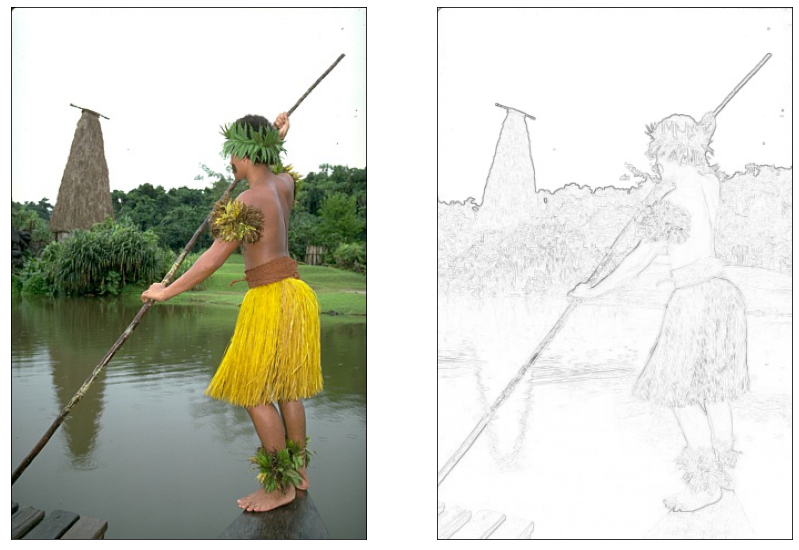

In [ ]:
image = imread("https://github.com/higra/Higra-Notebooks/raw/master/data/101087.jpg") / 255

graph = hg.get_4_adjacency_graph(image.shape[:2])  # create a 4-adjacency graph with the image size

edge_weights = hg.weight_graph(graph, image, weight_function=hg.WeightFunction.L2)  # compute a dissimilarity measure

print("Image and gradient")
plt.figure(figsize=(2 * 6 + 2, 10))
plt.subplot(1,2,1); plt.xticks([]); plt.yticks([]); plt.imshow(image);
plt.subplot(1,2,2); plt.xticks([]); plt.yticks([]); plt.imshow(1 - hg.graph_4_adjacency_2_khalimsky(graph, edge_weights), cmap="gray", interpolation="bilinear");

We compute:
 
1. watershed hierarchy by area 
2. the mean image color inside each node of the hierarchy: this is called an attribute

In [ ]:
# Watershed hierarchy by area
tree, altitudes = hg.watershed_hierarchy_by_area(graph, edge_weights)

# Mean pixel values inside each node of the tree
mean_color = hg.attribute_mean_vertex_weights(tree, image)

print("The attribute is just an array associating on or several values to each node of the tree:")
print("Number of nodes in the tree:", tree.num_vertices())
print("Shape of the attribute:", mean_color.shape)

The attribute is just an array associating on or several values to each node of the tree:
Number of nodes in the tree: 207149
Shape of the attribute: (207149, 3)


We then compute clustering with different number of clusters and we represent each region by its mean pixel color.

In [ ]:
# The HorizontalCutExplorer helps to computes cuts very efficiently in a hierarchy
cut_helper = hg.HorizontalCutExplorer(tree, altitudes)

def compute_cut(num_regions=20):
    cut = cut_helper.horizontal_cut_from_num_regions(num_regions)
    simplified = cut.reconstruct_leaf_data(tree, mean_color)
    plt.figure(figsize=[6,10]);plt.xticks([]); plt.yticks([]); plt.imshow(simplified);
    
interact(compute_cut, num_regions = IntSlider(min=1, max=100, continuous_update=False, value=20, step=1));

interactive(children=(IntSlider(value=20, continuous_update=False, description='num_regions', min=1), Output()…

A way to get an idea of the whole hierarchy in a single image is to use a dual representation called a *saliency map*

<div style="margin-top:50px">
    <img src="https://raw.githubusercontent.com/PerretB/Higra-Presentation/main/imgs/sm1.png" width="1000px" style="margin-left:auto;margin-right:auto;"/>
</div>

When the base graph is a 4 adjaceny graph, this saliency map can be represented as an image

<div style="margin-top:50px">
    <img src="https://raw.githubusercontent.com/PerretB/Higra-Presentation/main/imgs/khalimsky.svg" width="800px" style="margin-left:auto;margin-right:auto;"/>
</div>

Let's see how this work in Higra:

The saliency map is just an array associating an altitude to each edge of the graph:
Number of edges: 308000
Shape of the saliency map: (308000,)


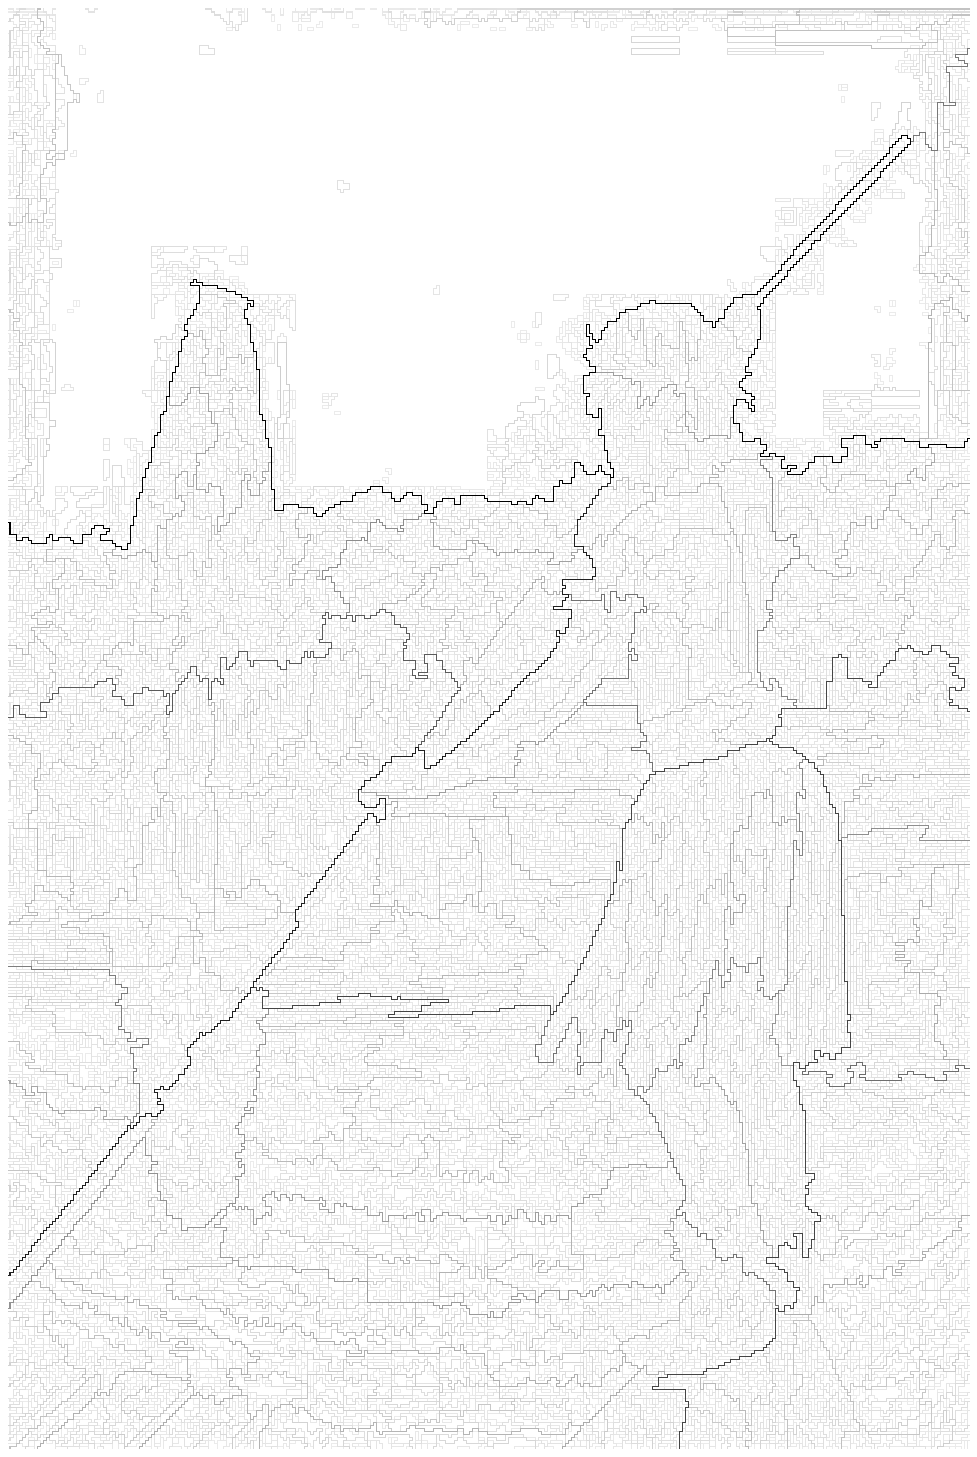

In [ ]:
saliency_map = hg.saliency(tree, altitudes)

print("The saliency map is just an array associating an altitude to each edge of the graph:")
print("Number of edges:", graph.num_edges())
print("Shape of the saliency map:", saliency_map.shape)

saliency_khalimsky = hg.graph_4_adjacency_2_khalimsky(graph, saliency_map)
imshow(1-saliency_khalimsky**0.25, cmap="gray");

## Exercise: marker based segmentation

In complex images, extracting a relevant segmentation from a hierarchy might require additional information.
Such additional information can be given as markers telling which part of the image belongs to objects of interests and which don't. In this exercise we will focus on the binary segmentation problem where we have only two kinds of markers: 

- $F$: foreground marker
- $B$: background marker

The markers are given by the user (or another automated procedure) on the pixels of the images, which correspond to the leaves of the hierarchy. The idea is then to propagate those markers through the hierarchy to find the nodes containing a pixel marked as foreground but no pixel marked as background. This can be done in two steps as illustrated in the figure below:


<div style="margin-top:50px">
    <img src="https://raw.githubusercontent.com/PerretB/Higra-Presentation/main/imgs/interactive_seg_algo.png" width="1000px"  style="margin-left:auto;margin-right:auto;"/>
</div>

We will work on the same image as before but with a better gradient: instead of using a L2 distance in the RGB space, we use a trained contour detector based on decision forests (Structured Edge Detection).

Image, gradient, marker, and saliency map


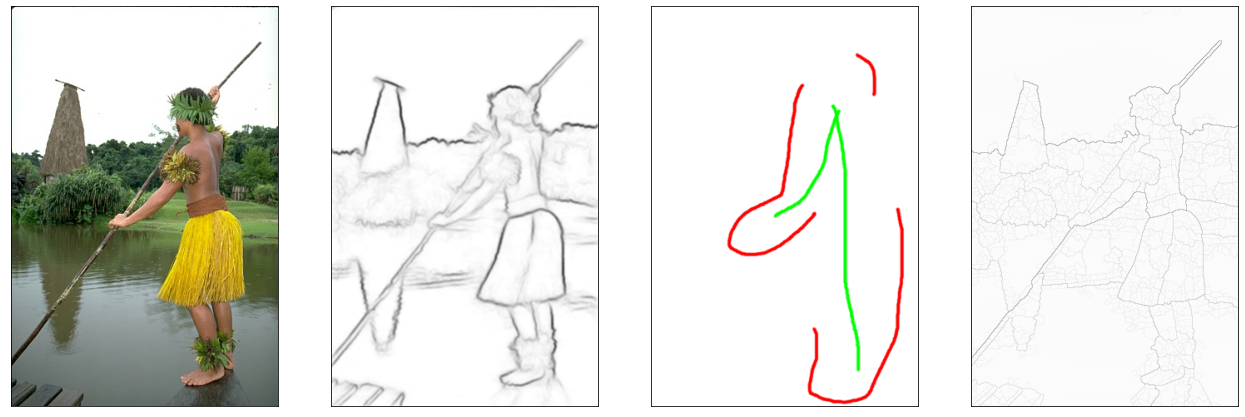

In [ ]:
image = imread("https://github.com/higra/Higra-Notebooks/raw/master/data/101087.jpg") / 255
grad = imread("https://github.com/higra/Higra-Notebooks/raw/master/data/101087_SED.png") / 255

graph = hg.get_4_adjacency_graph(image.shape[:2])  # create a 4-adjacency graph with the image size
edge_weights = hg.weight_graph(graph, grad, weight_function=hg.WeightFunction.mean)  # this time the edge weight is the mean of its two extremities

marker = imread("https://perso.esiee.fr/~perretb/tutoDGMM/marker.png")
foreground_marker = marker[:,:,1] > 0 # green channel
background_marker = marker[:,:,0] > 0 # red channel

tree, altitudes = hg.watershed_hierarchy_by_area(graph, edge_weights)

print("Image, gradient, marker, and saliency map")
plt.figure(figsize=(4 * 5 + 2, 8))
plt.subplot(1,4,1); plt.xticks([]); plt.yticks([]); plt.imshow(image);
plt.subplot(1,4,2); plt.xticks([]); plt.yticks([]); plt.imshow(1 - hg.graph_4_adjacency_2_khalimsky(graph, edge_weights), cmap="gray", interpolation="bilinear");
plt.subplot(1,4,3); plt.xticks([]); plt.yticks([]); plt.imshow(marker);
plt.subplot(1,4,4); plt.xticks([]); plt.yticks([]); plt.imshow(hg.graph_4_adjacency_2_khalimsky(graph, 1-hg.saliency(tree, altitudes)**0.25), cmap="gray", interpolation="bilinear");



### Question 1. Naive implementation of the marker propagation

To help you, the first step, bottom-up propagation, is already coded.

Usefull functions:

- [Tree node accessors](https://higra.readthedocs.io/en/stable/tree.html#basic-functions)
- [Tree node iterators](https://higra.readthedocs.io/en/stable/tree.html#iterators)
- [Children accessors](https://higra.readthedocs.io/en/stable/tree.html#children-relation)

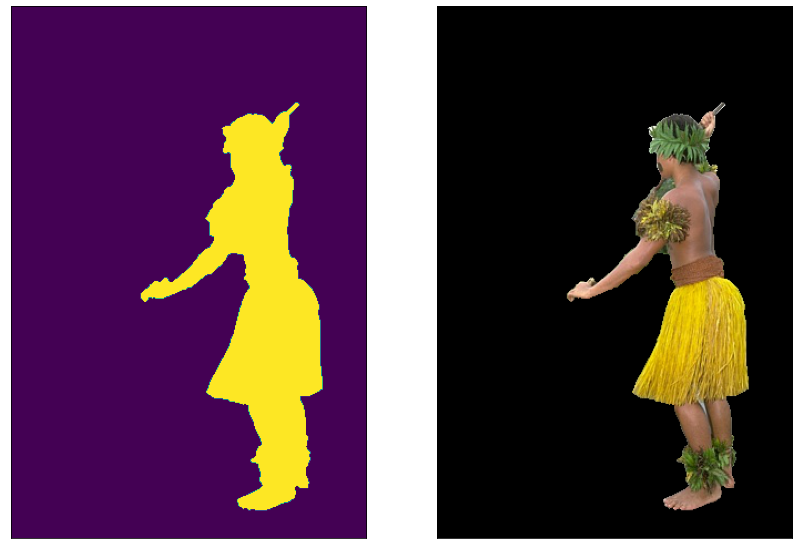

In [ ]:
def propagate_marker_naive(tree, foreground_marker, background_marker):
    """
    Compute a boolean array res of size tree.num_leaves() such that a leaf of index i belongs to the foreground <=> res[i] = True
    
    Parameters:
      - foreground_marker: a boolean array of size tree.num_leaves(): the leaf of index i is marked as foreground <=> foreground_marker[i] = True
      - background_marker: a boolean array of size tree.num_leaves(): the leaf of index i is marked as background <=> background_marker[i] = True
    
    """
    res = np.zeros(tree.num_leaves(), dtype=bool)
    
    # tree attributes, telling for each node if it contains a pixel marked as foreground (resp background)
    attr_foreground = np.zeros(tree.num_vertices(), dtype=bool)
    attr_background = np.zeros(tree.num_vertices(), dtype=bool)
    
    # intialize leaf values from input parameters
    attr_foreground[:tree.num_leaves()] = np.ravel(foreground_marker)
    attr_background[:tree.num_leaves()] = np.ravel(background_marker)
    
    # propagation
    for i in tree.leaves_to_root_iterator(include_root=False):
        p = tree.parent(i)
        attr_foreground[p] = attr_foreground[p] or attr_foreground[i]
        attr_background[p] = attr_background[p] or attr_background[i]
    
    
    ###  YOUR CODE HERE  ###
    # 2nd step: top-down propagation and res array filling
    # for all nodes n from root to leaves: 
    #   - if n is both background and foreground, then n becomes background
    #   - if n is neither foreground nor background, then n takes the label of its parent 
    for i in tree.root_to_leaves_iterator(include_root=False):
        if (not attr_foreground[i]) and (not attr_background[i]):
            p = tree.parent(i)
            attr_foreground[i] = attr_foreground[p]
            attr_background[i] = attr_background[p]
        elif attr_foreground[i] and attr_background[i]:
            attr_foreground[i] = False
    
    res[:] = attr_foreground[:tree.num_leaves()]
    ### END OF YOUR CODE ###
    return res.reshape(foreground_marker.shape)

# test your function!
res = propagate_marker_naive(tree, foreground_marker, background_marker)
plt.figure(figsize=(2 * 6 + 2, 10))
plt.subplot(1,2,1); plt.xticks([]); plt.yticks([]); plt.imshow(res);
im_res = image.copy(); im_res[np.logical_not(res), :]=0
plt.subplot(1,2,2); plt.xticks([]); plt.yticks([]); plt.imshow(im_res);

### Question 2. Optimized implementation of the marker propagation

The naive implementation is functional, but for loops are slow in Python. As with array programming, writting efficient algorithms with Higra in Python requires to use vectorized operations (that could be simply understood as: "the for loop is written in the C/C++ code instead of the Python code"). In addition to all the vectorized operations already provided by Numpy to operate on arrays, Higra defines several vectorized operations on trees grouped in two main categories:

- [Accumulators](https://higra.readthedocs.io/en/stable/tree.html#accumulators) aims at moving and transforming values from the leaves to the root of the tree.
- [Propagators](https://higra.readthedocs.io/en/stable/tree.html#propagators) aims at moving and transforming values from the root to the leaves.

To implement, the marker propagation we will need: 

- one accumulator to move the marker values from the leaves to the root of the tree: this will be the [sequential accumulator](https://higra.readthedocs.io/en/stable/tree.html#sequential-accumulator) ``hg.accumulate_sequential``
- one propagator to move the marker value from marked nodes to non marked nodes from the root to the leaves: this will be the [conditional sequential propagator](https://higra.readthedocs.io/en/stable/tree.html#conditional-sequential-propagator) ``hg.propagate_sequential``

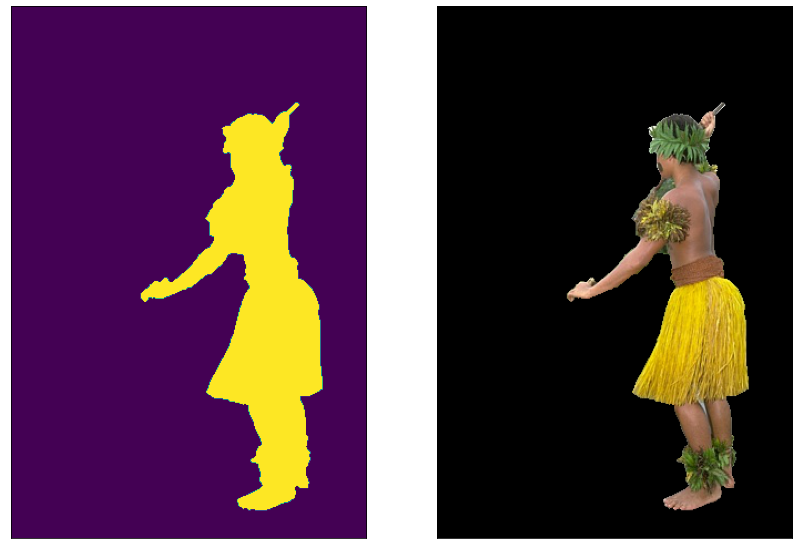

In [ ]:
def propagate_marker(tree, foreground_marker, background_marker):
    """
    Compute a boolean array res of size tree.num_leaves() such that a leaf of index i belongs to the foreground <=> res[i] = True
    
    Parameters:
      - foreground_marker: a boolean array of size tree.num_leaves(): the leaf of index i is marked as foreground <=> foreground_marker[i] = True
      - background_marker: a boolean array of size tree.num_leaves(): the leaf of index i is marked as background <=> background_marker[i] = True
    
    """
    # let's encode the markers in a single array to simplify further processing
    # note that the background marker has priority over the foreground marker: 
    # if both are present it will appear as background (value 2) 
    marker = np.maximum(foreground_marker, background_marker*2)
    
    ###  YOUR CODE HERE  ###
    
    # accumulation toward the root with hg.accumulate_sequential
    marker = hg.accumulate_sequential(tree, marker, hg.Accumulators.max)
    
    # propagation toward the leaves with hg.propagate_sequential (what should be the propagation condition?)
    marker = hg.propagate_sequential(tree, marker, marker==0)
    
    # fill in the result
    res = marker[:tree.num_leaves()] == 1
    
    ### END OF YOUR CODE ###
    
    return res.reshape(foreground_marker.shape)

# test your function!
res = propagate_marker(tree, foreground_marker, background_marker)
plt.figure(figsize=(2 * 6 + 2, 10))
plt.subplot(1,2,1); plt.xticks([]); plt.yticks([]); plt.imshow(res);
im_res = image.copy(); im_res[np.logical_not(res),:]=0
plt.subplot(1,2,2); plt.xticks([]); plt.yticks([]); plt.imshow(im_res);

Let's check that the vectorized approach is faster:

In [ ]:
print("Naive algorithm time:")
%timeit propagate_marker_naive(tree, foreground_marker, background_marker)
print("\nVectorized algorithm time (normally a speed-up of order 100x):")
%timeit propagate_marker(tree, foreground_marker, background_marker)

Naive algorithm time:
349 ms ± 9.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Vectorized algorithm time (normally a speed-up of order 100x):
2 ms ± 86 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Exercise: Combination of hierarchies

It is often not obvious to chose the right hierarchical segmentation method for the right image. In practice, different hierarchies will tend to exhibit different structures from the data. An interesting approach is then to combine different hierarchies to benefit from their different advantages.

In the following example, we see an image and the saliency maps of its hierarchical watershed by area and by dynamics.
We can see that the main contours are present in the watershed by area, but there are also many dubious and large contours present in the high level of the hierarchies. In the watershed by dynamics, we also have the main contours but there are also many small dubious contours corresponding to noise and thick contours in the image. The question is then, can we combine the watershed by area and the watershed by dynamics to promote the good contours and discard the other ones?

Image, watershed by dynamics, watershed by area


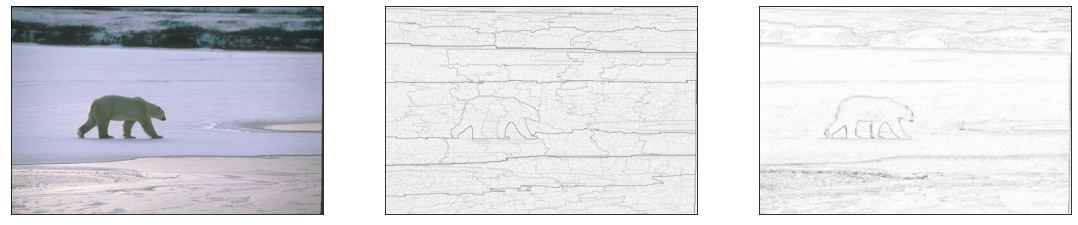

In [ ]:
image = imread("https://perso.esiee.fr/~perretb/tutoDGMM/100007.png")
graph = hg.get_4_adjacency_graph(image.shape[:2])  # create a 4-adjacency graph with the image size

edge_weights = hg.weight_graph(graph, image, weight_function=hg.WeightFunction.L2)  # compute a dissimilarity measure

tree_area, altitudes_area = hg.watershed_hierarchy_by_area(graph, edge_weights)
tree_dyn, altitudes_dyn = hg.watershed_hierarchy_by_dynamics(graph, edge_weights)

print("Image, watershed by dynamics, watershed by area")
plt.figure(figsize=(3 * 6 + 1, 8))
plt.subplot(1,3,1); plt.xticks([]); plt.yticks([]); plt.imshow(image);
plt.subplot(1,3,2); plt.xticks([]); plt.yticks([]); plt.imshow(1- hg.graph_4_adjacency_2_khalimsky(graph, hg.saliency(tree_area, altitudes_area)**0.25), cmap="gray", interpolation="bilinear");
plt.subplot(1,3,3); plt.xticks([]); plt.yticks([]); plt.imshow(1- hg.graph_4_adjacency_2_khalimsky(graph, hg.saliency(tree_dyn, altitudes_dyn)), cmap="gray", interpolation="bilinear");

There is no obvious way to combine two or more trees. However, the dual representation of hierarchies, the saliency maps, are simply functions which can be combined with classical pointwise functions such as teh average. The average of two saliency maps is generally not a saliency map, but we can however reconstruct a new hierarchy from this new map by taking for example, its canonical binary partition tree ([hg.bpt_canonical](https://higra.readthedocs.io/en/stable/python/hierarchy_core.html#higra.bpt_canonical)). To compute a meaningfull average, it is necessary to have comparable saliency maps; for example in watershed by area, the altitudes represent number of pixels while in watershed by dynamics, the altitudes represent a contrast. A simple way to solve this issue is to instead use the rank of appearance of the regions in the hierarchies: hence if we have a contour of level $k$ in the saliency map, it means that there are $k-1$ contours of lower level.

Let's make a little helper function to compute the rank of the nodes of a hierarchy. It's made very simple by the fact that regions are already sorted by their order of appearance in the hierarchy. We also had an extra parameter to control the number of regions we want to have.

Watershed by dynamics (200 regions), watershed by area (200 regions)


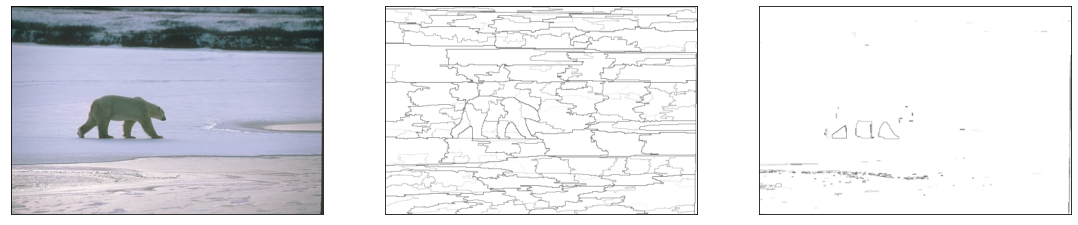

In [ ]:
def attribute_rank(tree, k=None):
    """
    The rank of a node, ie its order of appearance in the hierarchy.
    If k is not None, only the last k nodes are considered (others are set to 0, which discards the contours they represent).
    """
    nleaves = tree.num_leaves()
    nnodes = tree.num_vertices() - nleaves
    if k is None:
        k = nnodes
    return np.concatenate((np.zeros(tree_area.num_leaves() + nnodes - k), np.arange(1, k+1))) / k 


rank_area_200 = attribute_rank(tree_area, 200)
rank_dyn_200 = attribute_rank(tree_dyn, 200)

print("Watershed by dynamics (200 regions), watershed by area (200 regions)")
plt.figure(figsize=(3 * 6 + 1, 8))
plt.subplot(1,3,1); plt.xticks([]); plt.yticks([]); plt.imshow(image);
plt.subplot(1,3,2); plt.xticks([]); plt.yticks([]); plt.imshow(1- hg.graph_4_adjacency_2_khalimsky(graph, hg.saliency(tree_area, rank_area_200)), cmap="gray", interpolation="bilinear");
plt.subplot(1,3,3); plt.xticks([]); plt.yticks([]); plt.imshow(1- hg.graph_4_adjacency_2_khalimsky(graph, hg.saliency(tree_dyn, rank_dyn_200)), cmap="gray", interpolation="bilinear");

### Question: implement the combination of hierarchies

Now we have all set to compute the combination of the two hierarchies. To summarize the different steps to combine ``tree1`` with ``tree2`` are:

1. Compute the rank attributes of ``tree1`` and ``tree2``
2. Compute the saliency maps of ``tree1`` and ``tree2`` for their respective rank attributes
3. Compute the average of the saliency maps
4. Compute the canonical binary partition tree of the averaged saliency maps

Usefull functions:

- ``attribute_rank``
- [hg.saliency](https://higra.readthedocs.io/en/stable/python/hierarchy_core.html#higra.saliency)
- [hg.bpt_canonical](https://higra.readthedocs.io/en/stable/python/hierarchy_core.html#higra.bpt_canonical)


Image, combined saliency map (200 regions)


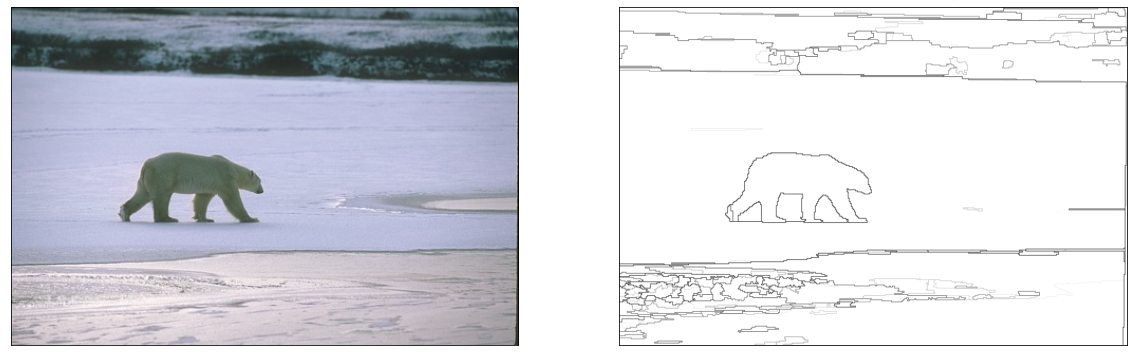

In [ ]:
def combine(tree1, tree2):
    tree, altitudes = None, None
    ###  YOUR CODE HERE  ###
    rank_tree1 = attribute_rank(tree1)
    rank_tree2 = attribute_rank(tree2)
    
    saliency_tree1 = hg.saliency(tree1, rank_tree1)
    saliency_tree2 = hg.saliency(tree2, rank_tree2)
    
    avg_saliency = (saliency_tree1 + saliency_tree2) / 2
    
    tree, altitudes = hg.bpt_canonical(graph, avg_saliency)
    
    ### END OF YOUR CODE ###
    return tree, altitudes

tree_combined, altitudes_combined = combine(tree_area, tree_dyn)
rank_combined_200 = attribute_rank(tree_combined, 200)

print("Image, combined saliency map (200 regions)")
plt.figure(figsize=(2 * 9 + 2, 8))
plt.subplot(1,2,1); plt.xticks([]); plt.yticks([]); plt.imshow(image);
plt.subplot(1,2,2); plt.xticks([]); plt.yticks([]); plt.imshow(1-hg.graph_4_adjacency_2_khalimsky(graph, hg.saliency(tree_combined, rank_combined_200)), cmap="gray", interpolation="bilinear");


# 2. Continuous optimization of hierarchical segmentations

Hierarchies of segmentations are combinatorial structures which usually do not fit well with continuous optimization methods commonly used in modern machine learning methods. However, we have seen that the hierarchy called in this presentation the canonical binary partition tree is indeed associated to a minimum spanning tree of the graph: there is a bijection between the internal nodes of this hierarchy and the edges of a minimum spanning tree. Moreover, the altitude of a node of this hierarchy is indeed equal to the weight of its associated edge. This means that any gradient on the altitudes of this tree can indeed be back-propagated to the edge weights of the graph. 

<div style="margin-top:50px">
    <img src="https://perso.esiee.fr/~perretb/tutoDGMM/mstbptmap2.svg" width="300px"  style="margin-left:auto;margin-right:auto;"/>
    <i>Each node of the canonical BPT (in blue) of the graph (in grey) is canonically associated (green dashed arrows) to an edge of a minimum spanning tree of the graph (thick edges): this edge is the pass edge between the leaves of the two children of the node.</i>
</div>

This means that we can indeed rewritte the function ``bpt_canonical`` so that it supports Pytorch autograd on the tree altitudes:

In [ ]:
def bpt_canonical(graph, edge_weights):
    """ 
    BPT canonical with differentiable altitudes
    
    :param graph: input graph (class ``higra.UndirectedGraph``)
    :param edge_weights: edge weights of the input graph (pytorch tensor, autograd is supported)
    :return: the tree and its altitudes (pytorch tensor) 
    """  
    # we discard the numpy altitudes and will recompute them from the mst and the paramter edge_weights  (pytorch world)
    tree, _ = hg.bpt_canonical(graph, edge_weights.detach().numpy())

    # associated minimum spanning
    mst = tree.mst
    
    # map mst edges to graph edges
    mst_map = mst.mst_edge_map

    # the altitudes of the internal nodes of the BPT are the weights of the MST edges
    altitudes_internal_nodes = edge_weights[mst_map]
    
    # just add zeros for the leaves
    altitudes = tc.cat((tc.zeros(tree.num_leaves(), dtype=edge_weights.dtype), altitudes_internal_nodes))
    
    return tree, altitudes


We will see how this can be used to fit a hierarchy defined by a loss function on some data.

Let's generate some moke up data composed of 3 Gaussian clusters of varied parameters.



Graph with the 3 clusters (orange, blue, green) and the points in the training set (squares)


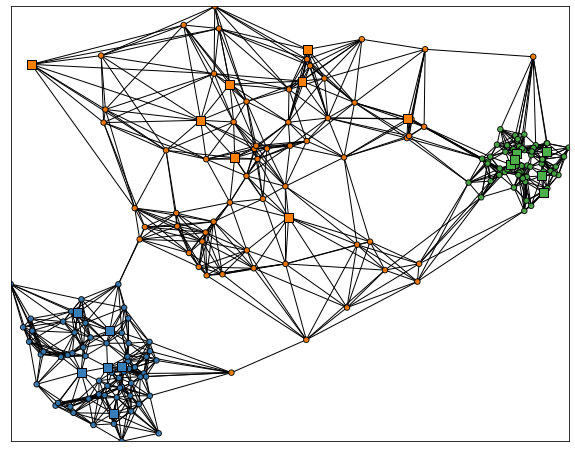

In [ ]:
data = create_dataset()

X = data["X"]                                       # points in the dataset
num_clusters = data["n_clusters"]                   # number of clusters in the dataset
y = data["y"]                                       # point labels
labeled = data["labeled"]                           # index of points in the training set
graph = data["graph"]                               # associated graph (KNN graph + MST to ensure connectedness)
edge_weights = tc.from_numpy(data["edge_weights"])  # edge weights (Euclidean distance between points)
                 

# display data
plt.figure(figsize=[10,8])
print("Graph with the 3 clusters (orange, blue, green) and the points in the training set (squares)")
plot_graph(graph, X, y, labeled)

A classical problem in hierarchy optimization is the *closest ultrametric* which is to find the hierarchy which minimizes the L2 distance between its saliency and the original edge weights of the graph. This can expressed as

$$loss_{L2}(H) = \frac{1}{|E|}\sum_{e\in E}(edge\_weights(e) - saliency_H(e))^2,$$

with $E$ the set of edges of the graph. 

The closest ultrametric problem naturally appears in phylogenetic tree estimations for example and is known to be NP hard. Let's see how we can optimize this loss function with gradient descent. 

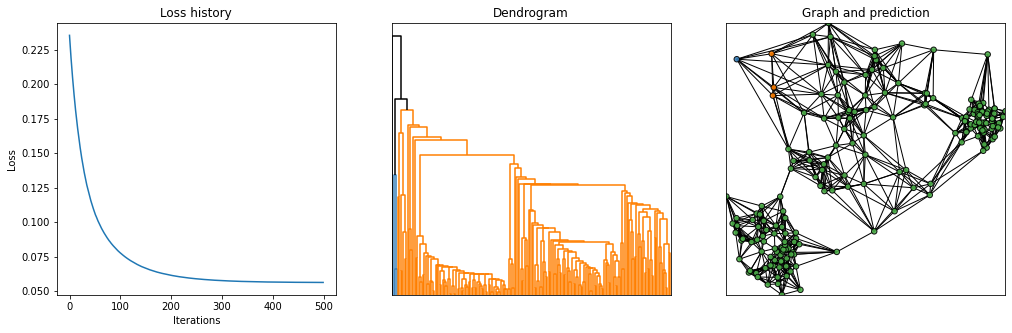

In [ ]:
def closest_saliency(tree, altitudes):
    
    #very easy to implement, note that hg.saliency is "Pytorch safe", it won't break autograd
    return tc.mean((hg.saliency(tree, altitudes) - edge_weights)**2)
    


# Note that the Optimizer uses the custom bpt_canonical function to transform edge_weights into a hierarchy with 
# differentiable altitudes
opt = OptimizerBPT(graph, closest_saliency, bpt_canonical, lr=0.01)

# Do the optimization
tree, altitudes = opt.fit(edge_weights.clone(), iter=500)

# Extract a clustering with num_clusters clusters from the optimized hierarchy
y_prediction = hg.labelisation_horizontal_cut_from_num_regions(tree, altitudes, num_clusters)
_, y_prediction =np.unique(y_prediction,return_inverse=True) # put labels between 0 and num_clusters-1

plt.figure(figsize=(3 * 5 + 2, 5))
plt.subplot(1,3,1);opt.show_history()
plt.subplot(1,3,2);plt.title("Dendrogram");plot_dendrogram(tree, altitudes, num_clusters, None)
plt.subplot(1,3,3);plt.title("Graph and prediction");plot_graph(data["graph"],data["X"],y_prediction)


The result is disapointing, the method failed to recover the 3 clusters. This is indeed not very suprising, mean square estimators are sensitive to outlyers and a regularizer is often needed to make them work properly. The good news is that we are in a continuous optimization context, so it is fairly easy to add regulizers, we just have to find a suitable formulation and incorporate them in the loss function.

We will now design two regularization terms:

1. The first one, will build upon the classical area filter, by penalizing the presence of small clusters close to the root of the hierarchy.
2. The second one, will build upon a classical semi-supervised learning loss, the contrastive loss, by enforcing some points to be in the same clusters while pushing others to be separated.



## Exercise: Cluster size regularization

In this exercise, we will see how to implement a regularization term that penalizes the precense of small clusters close to the root of the tree. Let's say that small clusters should not be present among the top $k$ nodes of the hierarchy. The cluster size loss can be formulated as:

$$loss_{size}(H) =  \frac{1}{Z}\sum_{n \in Top_k(H)} CL(n)*\frac{altitudes(n)}{\min\{area(c)\, | \, c\in Children(n)\}}$$

where 

- $Top_k(H)$ denotes the top $k$ nodes of $H$;
- $CL(n)$ denotes the number of edges in the contour represented by the node $c$ (ie, the number of edges, linking the first child of $n$ to its second child $n$);
- $Z=\sum_{n \in Top_k(H)}CL(n)$;
- $area(c)$ denotes the number of leaf nodes in the sub-tree rooted in $c$;

Implement the loss area function below.

Usefull functions:

- [hg.attribute_area](https://higra.readthedocs.io/en/stable/python/tree_attributes.html#higra.attribute_area)
- [hg.attribute_frontier_length](https://higra.readthedocs.io/en/stable/python/tree_attributes.html#higra.attribute_frontier_length)
- [hg.accumulate_parallel](https://higra.readthedocs.io/en/stable/tree.html#parallel-accumulator)
- [tc.tensor](https://pytorch.org/docs/stable/generated/torch.tensor.html#torch.tensor) convert a Numpy array to a Torch tensor


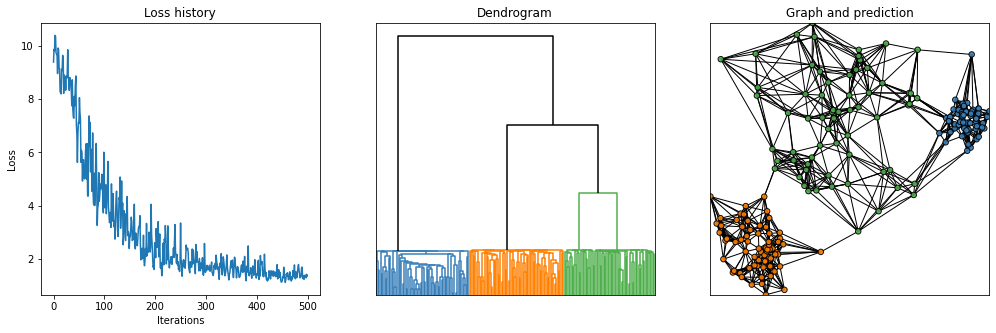

In [ ]:
def loss_area(tree, altitudes, top):
    loss = None
    
    ###  YOUR CODE HERE  ###
    w = tc.tensor(hg.attribute_frontier_length(tree))
    area = hg.attribute_area(tree)
    min_area = tc.tensor(hg.accumulate_parallel(tree, area, hg.Accumulators.min) , dtype=altitudes.dtype) 
    loss = tc.sum(w[-top:]*altitudes[-top:]/min_area[-top:])/tc.sum(w[-top:])
    ### END OF YOUR CODE ###
    
    return loss


def loss_closest_area(tree, altitudes, lambda1=10):
    """
    Loss combining the data attachment term and the cluster size regularization
    """
    return closest_saliency(tree, altitudes) + lambda1*loss_area(tree, altitudes, 10)
    

# Note that the Optimizer uses the custom bpt_canonical function to transform edge_weights into a hierarchy with 
# differentiable altitudes
opt = OptimizerBPT(graph, loss_closest_area, bpt_canonical, lr=0.01)

# Do the optimization
tree, altitudes = opt.fit(edge_weights.clone(), iter=500)

# Extract a clustering with num_clusters clusters from the optimized hierarchy
y_prediction = hg.labelisation_horizontal_cut_from_num_regions(tree, altitudes, num_clusters)
_, y_prediction =np.unique(y_prediction,return_inverse=True) # put labels between 0 and num_clusters-1


plt.figure(figsize=(3 * 5 + 2, 5))
plt.subplot(1,3,1);opt.show_history()
plt.subplot(1,3,2);plt.title("Dendrogram");plot_dendrogram(tree, altitudes, num_clusters, None)
plt.subplot(1,3,3);plt.title("Graph and prediction");plot_graph(data["graph"],data["X"],y_prediction)


## Exercise: Contrastive loss

In this exercise, we will see how to implement a semi-supervized loss term similar to the contrastive loss. In this context, we assume that we know the true label of a subset of the nodes of the graph. Then, remember that a hierarchical segmentation is indeed equivalent to an ultrametric distance: the distance between two vertices $x$ and $y$ is given by the altitude of the lowest common ancestor (lca) of $x$ and $y$ in the hierarchy. Thus if we know the labels $\ell_x$ and $\ell_y$ of $x$ and $y$ we can design a loss function that tries to decrease the ultrametric distance between $x$ and $y$ if they have the same label and tries to increase (up to a margin value) the ultrametric distance between $x$ and $y$ if they have different labels. THe contrastive loss is defined as:

$$loss_{cont}(H) =  \frac{1}{|P|}\sum_{(x,y)\in P} altitudes(lca_H(x,y)) + \frac{1}{|N|}\sum_{(x,y)\in N} \max(m-altitudes(lca_H(x,y)),0)$$

where 

- $P$ is a set of positive vertex pairs: ie. pairs of vertices which have the same labels;
- $N$ is a set of negative vertex pairs: ie. pairs of vertices which have different labels;
- $lca_H(x,y)$ is the lowes common ancestor of $x$ and $y$ in the hierarchy $H$;
- $m$ is a positive number called the margin (it prevents distances from growing toward infinity).

Implement the cosntrastive loss function below.

Usefull functions:

- [tree.lowest_common_ancestor](https://higra.readthedocs.io/en/stable/python/TreeGraph.html#higra.Tree.lowest_common_ancestor)
- [tree.lowest_common_ancestor_preprocess()](https://higra.readthedocs.io/en/stable/python/TreeGraph.html#higra.Tree.lowest_common_ancestor_preprocess)
- [tc.relu](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)



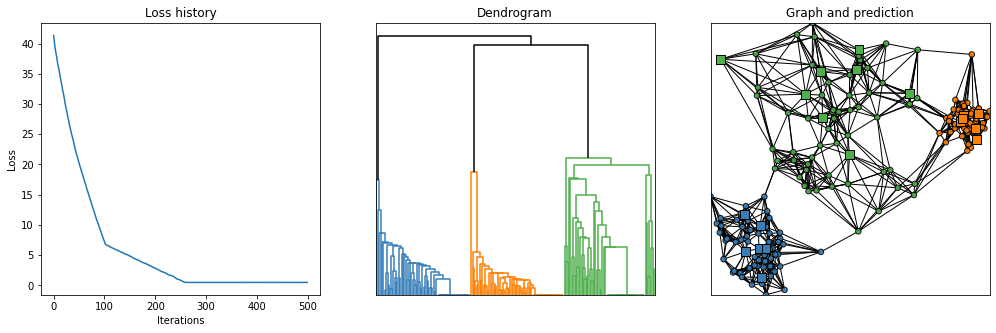

In [ ]:
def loss_contrastive(tree, altitudes, positive_pairs, negative_pairs, margin):
    """
    pairs are given as a tuple of two arrays (sources, destinations)
    """
    loss = None
    
    ###  YOUR CODE HERE  ###
    tree.lowest_common_ancestor_preprocess()
    positive_nodes = tree.lowest_common_ancestor(*positive_pairs)
    negative_nodes = tree.lowest_common_ancestor(*negative_pairs)
    
    loss = tc.mean(altitudes[positive_nodes]) + tc.mean(tc.relu(margin - altitudes[negative_nodes]))
    ### END OF YOUR CODE ###
    
    return loss
    

# create positive and negative pairs from the training set "labeled"
pos, neg = make_pairs(y[labeled], labeled)

def loss_closest_contrastive(tree, altitudes, lambda1=10):
    """
    Loss combining the data attachment term and the semi-supervized contrastive loss
    """
    return closest_saliency(tree, altitudes) + lambda1 * loss_contrastive(tree, altitudes, pos, neg, 5)
    
# Note that the Optimizer uses the custom bpt_canonical function to transform edge_weights into a hierarchy with 
# differentiable altitudes
opt = OptimizerBPT(graph, loss_closest_contrastive, bpt_canonical, lr=0.05)

# Do the optimization
tree, altitudes = opt.fit(edge_weights.clone(), iter=500)

# Extract a clustering with num_clusters clusters from the optimized hierarchy
y_prediction = hg.labelisation_horizontal_cut_from_num_regions(tree, altitudes, num_clusters)
_, y_prediction =np.unique(y_prediction,return_inverse=True) # put labels between 0 and num_clusters-1


plt.figure(figsize=(3 * 5 + 2, 5))
plt.subplot(1,3,1);opt.show_history()
plt.subplot(1,3,2);plt.title("Dendrogram");plot_dendrogram(tree, altitudes, num_clusters, None)
plt.subplot(1,3,3);plt.title("Graph and prediction");plot_graph(data["graph"],data["X"],y_prediction, labeled)


# The end!

[More notebooks with Higra here! °\(^▿^)/° ](https://higra.readthedocs.io/en/stable/notebooks.html)